In [1]:
from IPython.display import HTML,display
import numpy as np
from copy import copy
import warnings

def calc_ppid(P,verbose=False):
    with warnings.catch_warnings():
        ni,nj,nk=P.shape
        warnings.simplefilter("ignore")
        ix_p=-np.log2(P.sum((1,2))[:,None,None]*np.ones((1,nj,nk)))
        iy_p=-np.log2(P.sum((0,2))[None,:,None]*np.ones((ni,1,nk)))

        iy_m=-np.log2((P/(P.sum((0,1))[None,None,:])).sum(0)[None,:,:]*np.ones((ni,1,1)))
        ix_m=-np.log2((P/(P.sum((0,1))[None,None,:])).sum(1)[:,None,:]*np.ones((1,nj,1)))

        ixy_p=-np.log2(P)
        ixy_m=-np.log2((P/(P.sum((0,1))[None,None,:])))
        r_p=np.minimum(copy(ix_p),copy(iy_p),copy(ixy_p))
        r_m=np.minimum(copy(ix_m),copy(iy_m),copy(ixy_m))
        R=np.sum(P[P!=0]*(r_p[P!=0]-r_m[P!=0]))

        ux_p=ix_p-r_p
        ux_m=ix_m-r_m
        uy_p=iy_p-r_p
        uy_m=iy_m-r_m
        Ux=np.sum(P[P!=0]*(ux_p[P!=0]-ux_m[P!=0]))
        Uy=np.sum(P[P!=0]*(uy_p[P!=0]-uy_m[P!=0]))

        s_p=ixy_p-r_p-ux_p-uy_p
        s_m=ixy_m-r_m-ux_m-uy_m
        S=np.sum(P[P!=0]*(s_p[P!=0]-s_m[P!=0]))
    if verbose: 
        trs=['<td>{:}</td>'.format('</td><td>'.join(['$p$','$x$','$y$','$z$','$i_x^+$','$i_x^-$','$i_y^+$','$i_y^-$','$i_{xy}^+$','$i_{xy}^-$','$r^+$','$u_x^+$','$u_y^+$','$s^+$','$r^-$','$u_x^-$','$u_y^-$','$s^-$']))]
        for i,j,k in zip(*np.where(P!=0)):
            trs.append('<td>{:}</td>'.format('</td><td>'.join(['{:0.3f}'.format(e).rstrip('0').rstrip('.') for e in [P[i,j,k],i,j,k,ix_p[i,j,k],ix_m[i,j,k],iy_p[i,j,k],iy_m[i,j,k],ixy_p[i,j,k],ixy_m[i,j,k],r_p[i,j,k],ux_p[i,j,k],uy_p[i,j,k],s_p[i,j,k],r_m[i,j,k],ux_m[i,j,k],uy_m[i,j,k],s_m[i,j,k]]])))
        display(HTML('<table><tr>{:}</tr></table>'.format('</tr><tr>'.join(trs))))
        
        display(HTML('<table><tr>{:}</tr></table>'.format('</tr><tr>'.join(['<td>{:}</td><td>{:0.4f}</td>'.format(l,v) for l,v in [['R',R],['Ux',Ux],['Uy',Uy],['S',S]]]))))
    return Ux,Uy,R,S



In [2]:
# Example PwUnq (Figure 5)
P=np.zeros((3,3,3))

P[0,1,1]=1./4
P[1,0,1]=1./4
P[0,2,2]=1./4
P[2,0,2]=1./4

_=calc_ppid(P,verbose=True)

$p$,$x$,$y$,$z$,$i_x^+$,$i_x^-$,$i_y^+$,$i_y^-$,$i_{xy}^+$,$i_{xy}^-$,$r^+$,$u_x^+$,$u_y^+$,$s^+$,$r^-$,$u_x^-$,$u_y^-$,$s^-$
0.25,0,1,1,1,1,2,1,2,1,1,0,1,0,1,0,0,0
0.25,0,2,2,1,1,2,1,2,1,1,0,1,0,1,0,0,0
0.25,1,0,1,2,1,1,1,2,1,1,1,0,0,1,0,0,0
0.25,2,0,2,2,1,1,1,2,1,1,1,0,0,1,0,0,0


R,0.0000
Ux,0.5000
Uy,0.5000
S,0.0000


In [3]:
# Example RdnErr (Figure 6)
P=np.zeros((2,2,2))

P[0,0,0]=3./8
P[0,1,0]=1./8
P[1,0,1]=1./8
P[1,1,1]=3./8

_=calc_ppid(P,verbose=True)

$p$,$x$,$y$,$z$,$i_x^+$,$i_x^-$,$i_y^+$,$i_y^-$,$i_{xy}^+$,$i_{xy}^-$,$r^+$,$u_x^+$,$u_y^+$,$s^+$,$r^-$,$u_x^-$,$u_y^-$,$s^-$
0.375,0,0,0,1,-0,1,0.415,1.415,0.415,1,0,0,0.415,-0,0,0.415,0
0.125,0,1,0,1,-0,1,2,3,2,1,0,0,2,-0,0,2,0
0.125,1,0,1,1,-0,1,2,3,2,1,0,0,2,-0,0,2,0
0.375,1,1,1,1,-0,1,0.415,1.415,0.415,1,0,0,0.415,-0,0,0.415,0


R,1.0000
Ux,0.0000
Uy,-0.8113
S,0.8113


In [4]:
# Example Tbc (Figure 7)
P=np.zeros((2,2,4))

P[0,0,0]=1./4
P[0,1,1]=1./4
P[1,0,2]=1./4
P[1,1,3]=1./4

_=calc_ppid(P,verbose=True)

$p$,$x$,$y$,$z$,$i_x^+$,$i_x^-$,$i_y^+$,$i_y^-$,$i_{xy}^+$,$i_{xy}^-$,$r^+$,$u_x^+$,$u_y^+$,$s^+$,$r^-$,$u_x^-$,$u_y^-$,$s^-$
0.25,0,0,0,1,-0,1,-0,2,-0,1,0,0,1,-0,0,0,0
0.25,0,1,1,1,-0,1,-0,2,-0,1,0,0,1,-0,0,0,0
0.25,1,0,2,1,-0,1,-0,2,-0,1,0,0,1,-0,0,0,0
0.25,1,1,3,1,-0,1,-0,2,-0,1,0,0,1,-0,0,0,0


R,1.0000
Ux,0.0000
Uy,0.0000
S,1.0000


In [6]:
import itertools
from tqdm import tqdm_notebook as tqdm

def entropy(Fp,Hix):
    Hnot=tuple({0,1,2}-Hix)
    Fsum=np.sum(Fp,axis=Hnot)
    return -np.nansum(Fsum*np.log(Fsum))

def dgps(Fp):
    Hi=np.array([entropy(Fp,{i}) for i in range(3)])
    Hij=np.array([entropy(Fp,{0,1,2}-{i}) for i in range(3)])
    HijHjk=np.sum(Hij)-Hij
    Hijk=entropy(Fp,{0,1,2})
    omega=np.sum(Hi)-Hijk
    delta=(-Hi+HijHjk-Hijk)/omega
    Hall={'Hi':Hi,'Hij':Hij,'Hijk':Hijk}
    return delta,omega,Hall

a=3
ix=np.array([[k for k in range(a)]]*a)
x=ix.ravel(order='F')
y=ix.ravel(order='C')
D0=[]
Zlist0=[]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for Z in itertools.product([k for k in range(a)],repeat=a**2):
        p=np.zeros((a,a,a))
        p[x,y,Z]=1.0
        p=p/np.sum(p)
        d,o,_=dgps(p)
        D0.append(d)
        Zlist0.append(Z)
D0=np.vstack(D0).T
Zlist0=np.vstack(Zlist0)

Duq,Dix,Dinv=np.unique(D0.round(8),axis=1,return_inverse=True,return_index=True)
Zlist=[]
for dx in np.unique(Dinv):
    Zx=Zlist0[Dinv==dx]
    za=np.array([len(np.unique(z)) for z in Zx])
    Zx=Zx[za==np.max(za)][0]
    Zlist.append(Zx)
Zlist=np.vstack(Zlist)

In [8]:
D=[]
PID=[]
for Z in tqdm(Zlist):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p=np.zeros((a,a,a))
        p[x,y,Z]=1.0
        p=p/np.sum(p)
        d,_,_=dgps(p)
        ux,uy,r,s=calc_ppid(p)
        PID.append([ux,uy,r,s])
        D.append(d)
D=np.vstack(D).round(8).T
PID=np.vstack(PID).T

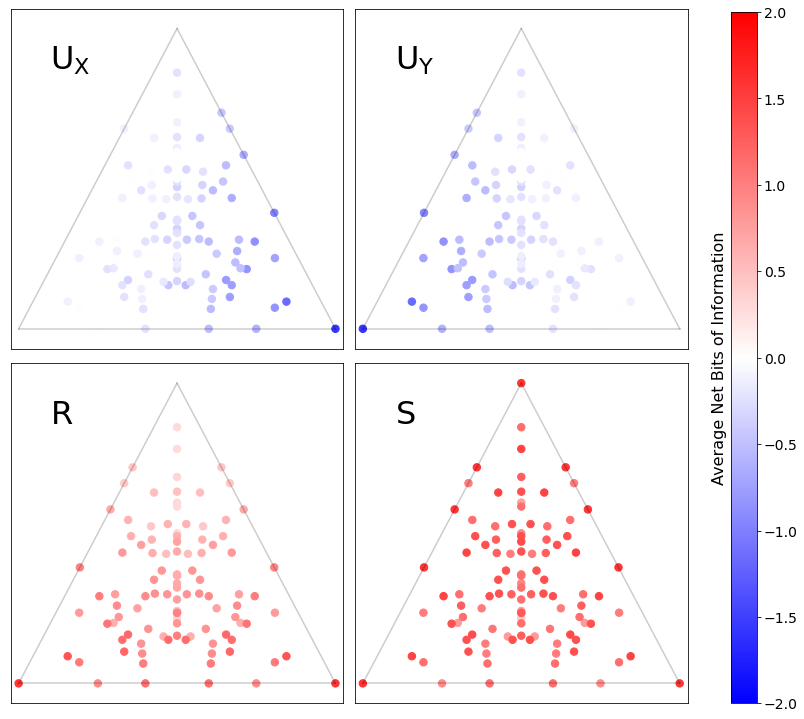

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

labels=['$\mathrm{U_X}$','$\mathrm{U_Y}$','$\mathrm{R}$','$\mathrm{S}$']
fig=plt.figure(figsize=(12,10))
ax=[]

vb=np.max(np.abs(PID))
vb=2
for k in range(4):
    ax.append(plt.subplot(2,2,k+1))

    #ax[-1].set_axis_off()
    x=D[0]-D[1]
    y=(D[0]+D[1]+2*D[2])/4
    z=PID[k]
    #z=PID[k]

    ix=np.argsort(z)
    x=x[ix]
    y=y[ix]
    z=z[ix]
    
    plt.plot([-1,1],[0.25,0.25],c=[0,0,0,0.2])
    plt.plot([-1,0],[0.25,1],c=[0,0,0,0.2])
    plt.plot([0,1],[1,0.25],c=[0,0,0,0.2])
    
    #im=plt.scatter(x,y,c=z,alpha=1.0,vmin=PID.min(),vmax=PID.max(),s=55,cmap='viridis')
    im=plt.scatter(x,y,c=z,s=55,cmap='bwr',vmin=-vb,vmax=vb)
    
    plt.xlim([-1.05,1.05])
    plt.ylim([0.2,1.05])
    plt.xticks([]);plt.yticks([])
    #plt.title('{:}'.format(labels[k]))
    plt.text(-0.8,0.9,'{:}'.format(labels[k]),fontsize=32,fontweight='roman')
    
plt.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.02, 0.03, 0.96])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='Average Net Bits of Information',fontsize=16)
cbar.ax.yaxis.set_label_position('left')

plt.savefig('./fig7_pointwise.png',dpi=200)